Split the protocol into training, validation and testing set and then augment and train.

In [1]:
# Load libraries and modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from modelval import pairptl, network, trainer, dataset, dw_gen, perform_eval
from modelval.ArbDataGen import arb_w_gen
from modelval.spk_visu import spk_see, raster

import warnings
warnings.filterwarnings('ignore')

% matplotlib inline
% load_ext autoreload
% autoreload 2

In [2]:
# Load data frame
data = pd.read_csv('/src/Plasticity_Ker/data/kernel_training_data_auto.csv')
data.head()

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,1,1,0,1,0,60,1.0,-102.898046,0.0,0,-1.322590,0.0,60
1,1,1,0,1,0,60,1.0,-75.579896,0.0,0,2.674768,0.0,60
2,1,1,0,1,0,60,1.0,-80.871473,0.0,0,-12.696449,0.0,60
3,1,1,0,1,0,60,1.0,-67.562239,0.0,0,0.231446,0.0,60
4,1,1,0,1,0,60,1.0,-63.553410,0.0,0,-0.990216,0.0,60


In [3]:
# Generate data for STDP
data1 = data[data['ptl_idx']==1]
data1_gen, targets1 = dw_gen.STDP_dw_gen(n_neighbors=3)

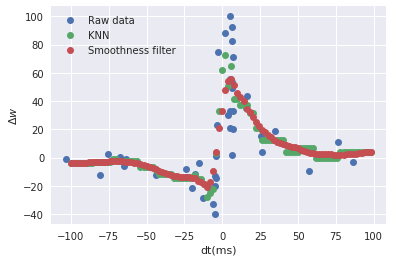

In [4]:
plt.plot(data1['dt1'], data1['dw_mean'],'o', label='Raw data')
width_list = np.concatenate([np.linspace(10,3,50), np.linspace(3,10,50)])
plt.plot(data1_gen['dt1'], targets1,'o', label='KNN')
targets1_sm = dw_gen.smooth(targets1,width_list = width_list)
plt.plot(data1_gen['dt1'],targets1_sm,'o', label='Smoothness filter')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')
plt.legend(loc='upper left')

70 20 10


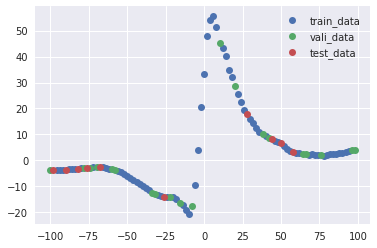

In [5]:
# Sample randomly the smoothed STDP data
samp_len = len(targets1_sm)
np.random.seed(1)
test_idx_stdp = np.unique(np.random.randint(low=0, high=100, size=10))
train_vali_idx = np.setdiff1d(np.linspace(0,99,100), test_idx_stdp).astype(int)
np.random.seed(10)
vali_idx_idx = np.random.randint(low=0, high=90, size=20)
vali_idx_stdp = np.unique(train_vali_idx[vali_idx_idx])
train_idx_stdp = np.setdiff1d(train_vali_idx, vali_idx_stdp).astype(int)
plt.plot(data1_gen.loc[train_idx_stdp]['dt1'],targets1_sm[train_idx_stdp],'o', label='train_data')
plt.plot(data1_gen.loc[vali_idx_stdp]['dt1'],targets1_sm[vali_idx_stdp],'o', label='vali_data')
plt.plot(data1_gen.loc[test_idx_stdp]['dt1'],targets1_sm[test_idx_stdp],'o', label='test_data')
plt.legend()
print(len(set(train_idx_stdp)), len(set(vali_idx_stdp)), len(set(test_idx_stdp)))

In [6]:
# Generate data for Triplet
dt = np.array([-10, -5, 0, 5, 10]).reshape(-1,1)
data2_gen, targets2 = dw_gen.triplet_dw_gen(dt)

In [7]:
# Visualize the triplet data
data2_gen

,ptl_idx,pre_spk_num,pre_spk_freq,post_spk_num,post_spk_freq,ptl_occ,ptl_freq,dt1,dt2,dt3,dw_mean,dw_ste,train_len
0,2.0,2.0,0.0,1.0,0.0,60.0,1.0,-10.0,10.0,0.0,2.634968,0.000000,60.0
1,2.0,2.0,0.0,1.0,0.0,60.0,1.0,-5.0,5.0,0.0,-0.162906,0.000000,60.0
2,2.0,2.0,0.0,1.0,0.0,60.0,1.0,0.0,0.0,0.0,50.000000,0.000000,60.0
3,2.0,1.0,0.0,2.0,0.0,60.0,1.0,5.0,-5.0,0.0,27.321098,0.000000,60.0
4,2.0,1.0,0.0,2.0,0.0,60.0,1.0,10.0,-10.0,0.0,25.392321,0.000000,60.0
139,4.0,2.0,0.0,1.0,0.0,60.0,1.0,-15.0,5.0,0.0,0.246154,3.354050,60.0
140,4.0,2.0,0.0,1.0,0.0,60.0,1.0,-5.0,15.0,0.0,23.154206,4.891500,60.0
141,4.0,1.0,0.0,2.0,0.0,60.0,1.0,5.0,-15.0,0.0,20.722837,7.546790,60.0
142,4.0,1.0,0.0,2.0,0.0,60.0,1.0,15.0,-5.0,0.0,28.118581,4.751571,60.0


In [8]:
# Generate data for Quadruplet
data3 = data[data['ptl_idx']==3]
data3_gen, targets3 = dw_gen.quad_dw_gen(n_neighbors=7)

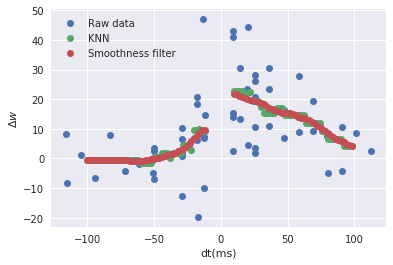

In [9]:
width_list = np.concatenate([np.linspace(10,3,45), np.linspace(3,10,45)])
plt.plot(data3['dt2'], data3['dw_mean'],'o', label='Raw data')
plt.plot(data3_gen['dt2'], targets3,'o', label='KNN')
targets3_sm = np.concatenate([dw_gen.smooth(targets3[:45],width_list = width_list), dw_gen.smooth(targets3[45:],width_list = width_list)])
plt.plot(data3_gen['dt2'],targets3_sm,'o', label='Smoothness filter')
plt.xlabel('dt(ms)')
plt.ylabel('$\Delta w$')
plt.legend(loc='upper left')

63 18 9


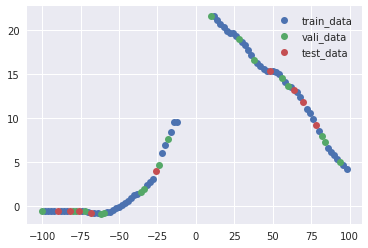

In [10]:
# Sample randomly the smoothed Quadruplet data
samp_len = len(targets3_sm)
np.random.seed(1)
test_idx_quad = np.unique(np.random.randint(low=0, high=90, size=9))
train_vali_idx = np.setdiff1d(np.linspace(0,89,90), test_idx_quad).astype(int)
np.random.seed(10)
vali_idx_idx = np.random.randint(low=0, high=80, size=18)
vali_idx_quad = np.unique(train_vali_idx[vali_idx_idx])
train_idx_quad = np.setdiff1d(train_vali_idx, vali_idx_quad).astype(int)
plt.plot(data3_gen.loc[train_idx_quad]['dt2'],targets3_sm[train_idx_quad],'o', label='train_data')
plt.plot(data3_gen.loc[vali_idx_quad]['dt2'],targets3_sm[vali_idx_quad],'o', label='vali_data')
plt.plot(data3_gen.loc[test_idx_quad]['dt2'],targets3_sm[test_idx_quad],'o', label='test_data')
plt.legend()
print(len(set(train_idx_quad)), len(set(vali_idx_quad)), len(set(test_idx_quad)))

In [11]:
trip_para = pd.read_pickle('/src/Plasticity_Ker/data/Gerstner_trip_para_df')
trip_para
# Reorder columns to match parameter of the model
trip_para = trip_para[['A2_+', 'A3_-', 'A2_-', 'A3_+', 'Tau_+', 'Tau_x', 'Tau_-', 'Tau_y']]
trip_para

A2_+     A3_-    A2_-    A3_+ Tau_+ Tau_x Tau_-  \
Visu_AlltoAll    Full    5e-10  0.00023   0.007  0.0062  16.8   101  33.7   
                 Min         0        0  0.0071  0.0065  16.8     1  33.7   
Visu_NearestSpk  Full  8.8e-11   0.0031  0.0066   0.053  16.8   714  33.7   
                 Min         0        0   0.008    0.05  16.8     1  33.7   
Hippo_AlltoAll   Full   0.0061   0.0014  0.0016  0.0067  16.8   946  33.7   
                 Min    0.0053        0  0.0035   0.008  16.8     1  33.7   
Hippo_NearestSpk Full   0.0046  7.5e-09   0.003  0.0091  16.8   575  33.7   
                 Min    0.0046        0   0.003  0.0091  16.8     1  33.7   

                      Tau_y  
Visu_AlltoAll    Full   125  
                 Min    114  
Visu_NearestSpk  Full    40  
                 Min     40  
Hippo_AlltoAll   Full    27  
                 Min     40  
Hippo_NearestSpk Full    47  
                 Min     48

In [12]:
# Visualize kernel
from modelval.kernel import KernelGen
ker_test = KernelGen()

para = trip_para.loc[('Hippo_AlltoAll', 'Full'), :]
a = para[:4].values
tau = para[4:].values
reso_set = 2
tau_pre_post = tau[0]/reso_set  # ms
tau_post_pre = tau[2]/reso_set # ms

ker_test = KernelGen(len_kernel=101)
ker_test.trip_model_ker(para, data_name='Hippocampus')

In [13]:
data_gen_train = pd.concat([data1_gen.loc[train_idx_stdp],data2_gen, data3_gen.loc[train_idx_quad]])
targets_gen_train = np.concatenate([targets1_sm[train_idx_stdp], targets2, targets3_sm[train_idx_quad]])

In [14]:
data_gen_vali = pd.concat([data1_gen.loc[vali_idx_stdp], data2_gen, data3_gen.loc[vali_idx_quad]])
targets_gen_vali = np.concatenate([targets1_sm[vali_idx_stdp], targets2, targets3_sm[vali_idx_quad]])

In [15]:
data_gen_test = pd.concat([data1_gen.loc[test_idx_stdp], data2_gen, data3_gen.loc[test_idx_quad]])
targets_gen_test = np.concatenate([targets1_sm[test_idx_stdp], targets2, targets3_sm[test_idx_quad]])

In [27]:
len_stdp = len(vali_idx_stdp)*20
len_triplet = len(vali_idx_stdp)*20+len(data2_gen[data2_gen['ptl_idx']==2])*40
len_trip2 = len(vali_idx_stdp)*20+len(data2_gen[data2_gen['ptl_idx']==2])*40+len(data2_gen[data2_gen['ptl_idx']==4])*40
len_quad = len(targets_gen_vali) - len_trip2

In [16]:
data_gen_train['ptl_idx'].value_counts()

1.0    70
3.0    63
2.0     5
4.0     4
Name: ptl_idx, dtype: int64

In [17]:
# Generat the spike trains and targets for STDP
ptl_list = [1,2,4,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [20,40,40,20]
spk_pairs_train, targets_train = arb_w_gen(df=data_gen_train, ptl_list=ptl_list, targets=targets_gen_train, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [18]:
# Generat the spike trains and targets for Quadruplet
ptl_list = [1,2,4,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 1
aug_times = [20,40,40,20]
spk_pairs_vali, targets_vali = arb_w_gen(df=data_gen_vali, ptl_list=ptl_list, targets=targets_gen_vali, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)

In [19]:
spk_pairs_train.shape, spk_pairs_vali.shape

((3020, 30000, 2), (1120, 30000, 2))

In [20]:
# Create the network
ground_truth_init = 0
reg_scale=(1, 1)
init_seed=(4,5,6,7)
toy_data_net = network.TripNet(kernel=ker_test, ground_truth_init=ground_truth_init, init_seed=init_seed, reg_scale=reg_scale, n_input=spk_pairs_train.shape[1])

In [21]:
# Create the trainer
save_dir= '/src/Plasticity_Ker/model/Trip_ptl1_4_real_aug'
toy_net_trainer = trainer.Trainer(toy_data_net.loss, toy_data_net.loss, input_name=toy_data_net.inputs, target_name=toy_data_net.target, save_dir=save_dir, optimizer_config={'learning_rate': toy_data_net.lr})

In [22]:
train_data = dataset.Dataset(spk_pairs_train, targets_train)
vali_data = dataset.Dataset(spk_pairs_vali, targets_vali)

[-0.03211808  0.01240611 -0.48971248] 0.0


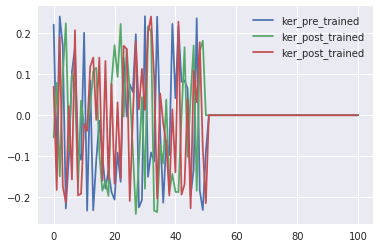

In [23]:
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(w_pre,  label='ker_pre_trained')
plt.plot(w_post,  label='ker_post_trained')
plt.plot(w_post_post,  label='ker_post_trained')
plt.legend()
print(fc_w, bias)

In [26]:
# Learn the kernel from random initialization
learning_rate = 0.001
iterations = 5
min_error = -1
for i in range(iterations):
    toy_net_trainer.train(train_data, vali_data, batch_size=128, min_error=min_error, feed_dict={toy_data_net.lr: learning_rate})
    learning_rate = learning_rate/3

Global Step 3700 and Step 0043: validation cost=11.82162
Updated min validation loss!Saving model...
Global Step 3750 and Step 0093: validation cost=11.90527
Global Step 3800 and Step 0143: validation cost=11.86234
Global Step 3850 and Step 0193: validation cost=11.86875
Global Step 3900 and Step 0243: validation cost=11.86755
Global Step 3950 and Step 0293: validation cost=11.93640
Global Step 4000 and Step 0343: validation cost=12.06453
Global Step 4050 and Step 0393: validation cost=12.17760
Global Step 4100 and Step 0443: validation cost=11.95865
Global Step 4150 and Step 0493: validation cost=11.96438
Global Step 4200 and Step 0543: validation cost=12.03053
Global Step 4250 and Step 0593: validation cost=12.06677
Global Step 4300 and Step 0643: validation cost=12.05904
Global Step 4350 and Step 0693: validation cost=12.07592
Global Step 4400 and Step 0743: validation cost=12.12991
Global Step 4450 and Step 0793: validation cost=12.11439
Early Stopping!!!
Restoring the best paramet

KeyboardInterrupt: 

[array([-0.92733234, -0.79123598, -1.08158243], dtype=float32), 0.7875514]


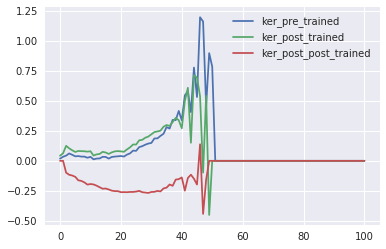

In [25]:
toy_net_trainer.restore_best()
w_pre = toy_net_trainer.evaluate(ops=toy_data_net.kernel_pre)
w_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post)
w_post_post = toy_net_trainer.evaluate(ops=toy_data_net.kernel_post_post)
fc_w = toy_net_trainer.evaluate(ops=toy_data_net.fc_w)
bias = toy_net_trainer.evaluate(ops=toy_data_net.bias)
plt.plot(-1*w_pre, label='ker_pre_trained')
plt.plot(-1*w_post, label='ker_post_trained')
plt.plot(-1*w_post_post, label='ker_post_post_trained')
plt.legend()
print([fc_w, bias])

In [ ]:
# # Test effect of smoothed kernel
# w_pre_sm = w_pre
# w_post_sm = w_post 
# w_post_post_sm = w_post_post
# w_pre_sm[:50] = dw_gen.smooth(w_pre[:50], width=2)
# w_post_sm[:48] = dw_gen.smooth(w_post[:48], width=2)
# w_post_post_sm[:49] = dw_gen.smooth(w_post_post[:49], width=3)

# plt.plot(-1 * w_pre_sm)
# plt.plot(-1 * w_post_sm)
# plt.plot(-1*w_post_post_sm)

# ker_test.kernel_pre = w_pre_sm
# ker_test.kernel_post = w_post_sm
# ker_test.kernel_post_post= w_post_post_sm
# ker_test.kernel_scale = fc_w
# ker_test.bias = bias

Compare the target and prediction

In [28]:
ker_test.kernel_pre = w_pre
ker_test.kernel_post = w_post
ker_test.kernel_post_post= w_post_post
ker_test.kernel_scale = fc_w
ker_test.bias = bias

In [29]:
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs_vali, spk_len=spk_len, kernel=ker_test, net_type='triplet')

In [ ]:
# np.save('/src/Plasticity_Ker/data/predictions.npy', predictions)
# predictions = np.load('/src/Plasticity_Ker/data/predictions.npy')

In [31]:
targets=targets_vali
x_fit = np.linspace(np.min(targets)-1, np.max(targets)+1, 100)
targets_stdp = targets[:len_stdp]
predictions_stdp = predictions[:len_stdp]
targets_triplet = targets[len_stdp:len_triplet]
predictions_triplet = predictions[len_stdp:len_triplet]
targets_trip2 = targets[len_triplet:len_trip2]
predictions_trip2 = predictions[len_triplet:len_trip2]
targets_quad = targets[len_trip2:]
predictions_quad = predictions[len_trip2:]
R2, corr, y_fit = perform_eval.R2_corr(predictions,targets, x_fit)
R2_stdp, corr_stdp, y_fit_stdp = perform_eval.R2_corr(predictions_stdp,targets_stdp, x_fit)
R2_triplet, corr_triplet, y_fit_triplet = perform_eval.R2_corr(predictions_triplet,targets_triplet, x_fit)
R2_quad, corr_quad, y_fit_quad = perform_eval.R2_corr(predictions_quad ,targets_quad, x_fit)
R2_quad, corr_trip2, y_fit_trip2 = perform_eval.R2_corr(predictions_trip2 ,targets_trip2, x_fit)

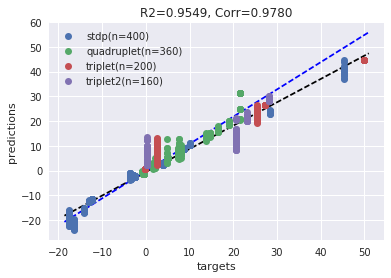

In [33]:
plt.plot(x_fit, y_fit_stdp, 'k--')
#plt.plot(x_fit, y_fit_triplet, 'r--')
plt.plot(x_fit, y_fit_quad, 'b--')

plt.plot(targets_stdp, predictions_stdp, 'o', label='stdp(n={a})'.format(a=len_stdp))
plt.plot(targets_quad, predictions_quad, 'o', label='quadruplet(n={a})'.format(a=len(targets)-len_trip2))
plt.plot(targets_triplet, predictions_triplet, 'o', label='triplet(n={a})'.format(a=(len_triplet-len_stdp)))
plt.plot(targets_trip2, predictions_trip2, 'o', label='triplet2(n={a})'.format(a=(len_trip2-len_triplet)))


plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))
plt.legend()

In [46]:
# Generat the spike trains and targets for Quadruplet
ptl_list = [1,2,4,3]
spk_len = int(data3_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
if_noise = 0
aug_times = [1,1,1,1]
spk_pairs_test, targets_test = arb_w_gen(df=data_gen_test, targets=targets_gen_test, ptl_list=ptl_list, if_noise=if_noise, spk_len=spk_len, kernel=ker_test, net_type='triplet', aug_times=aug_times)
test= spk_pairs_test

Generate test restuls

In [47]:
ptl_list = [1,2,4,3]
spk_len = int(data1_gen['train_len'].max() * 1000 / ker_test.reso_kernel)
spk_pairs, predictions = arb_w_gen(spk_pairs=spk_pairs_test, df=data1_gen, ptl_list=ptl_list, spk_len=spk_len, kernel=ker_test, aug_times=[20])

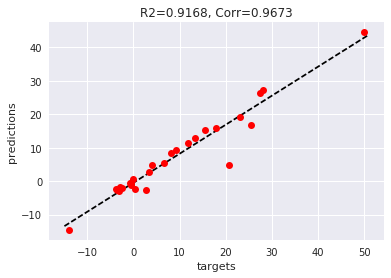

In [48]:
# Calculate R square
R2 = 1 - np.sum(np.square(predictions - targets_test))/np.sum(np.square(targets_test - np.mean(targets_test)))
# Calculate correlation coefficient
corr = np.sum(np.dot((predictions - np.mean(predictions)).T, targets_test- np.mean(targets_test)))/np.std(predictions)/np.std(targets_test)/len(targets_test)
b1 = np.sum(np.dot((predictions - np.mean(predictions)).T, targets_test - np.mean(targets_test)))/np.sum(np.square(targets_test - np.mean(targets_test)))
b2 = np.mean(predictions) - np.mean(targets_test)*b1
x_fit = np.linspace(np.min(targets_test)-1, np.max(targets_test)+1, 100)
y_fit = x_fit * b1 + b2
plt.plot(x_fit, y_fit, 'k--')
plt.plot(targets_test, predictions, 'ro')
plt.xlabel('targets')
plt.ylabel('predictions')
plt.title(''.join(('R2=%.4f'%(R2), ', Corr=%.4f'%(corr))))